In [20]:
import json
from collections import defaultdict, Counter
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse
import statsmodels.api as sm
import random
from sklearn.metrics import precision_recall_curve
from matplotlib.patches import Rectangle


In [21]:
#ped_file = '../../DATA/spark/spark.ped'
#phase_dir = '../phased_spark_del'

ped_file = '../../DATA/ihart.v34/ihart.ped'
wgs_phase_dir = '../phased_ihart.v34_del'
chip_phase_dir = '../phased_ihart.chip_del'

In [22]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
in_ped = set()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            #if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                #child_id = ssc_old_id_to_new_id[child_id]
                #f_id = ssc_old_id_to_new_id[f_id]
                #m_id = ssc_old_id_to_new_id[m_id]
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

            if (fam_id, m_id, f_id) not in fam_to_inds:
                fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
            fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
            in_ped.add(m_id)
            in_ped.add(f_id)
            in_ped.add(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 4611


In [26]:
wgs_deletions = []
wgs_notrans_deletions = []
with open('%s/deletions.json' % wgs_phase_dir) as f:
    for d in json.load(f):
        if d['is_inherited'] and d['family_size']>=4:
            for child in d['trans']:
                wgs_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers_ihart.chip': d['num_markers_ihart.chip']
                        })
            for child in d['notrans']:
                wgs_notrans_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers_ihart.chip': d['num_markers_ihart.chip']
                        })
                
chip_deletions = []
chip_notrans_deletions = []
with open('%s/deletions.json' % chip_phase_dir) as f:
    for d in json.load(f):
        if d['is_inherited'] and d['family_size']>=4:
            for child in d['trans']:
                chip_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers': d['num_markers']
                        })
            for child in d['notrans']:
                chip_notrans_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers': d['num_markers']
                        })
                
print('remaining deletions', 'wgs', len(wgs_deletions), 'chip', len(chip_deletions))


remaining deletions wgs 315581 chip 583


In [27]:
with open('../../FamilySeqError/params/ihart.chip_params.json', 'r') as f:
    params = json.load(f)
    
child_id_to_num_probes = dict([(k.split('.')[1], v['total_count']-v['observed_./.']) for k, v in params.items()])


In [28]:
with open('%s/individuals.json' % wgs_phase_dir) as f:
    wgs_individuals = set(json.load(f))
    
with open('%s/families.json' % wgs_phase_dir) as f:
    wgs_families = set(json.load(f))

print('wgs', 'individuals', len(wgs_individuals), 'families', len(wgs_families))

with open('%s/individuals.json' % chip_phase_dir) as f:
    chip_individuals = set([x for x in json.load(f) if child_id_to_num_probes[x]>300000])

# need to do it this way due to filtering on probes      
chip_families = set([k[0] for k, v in fam_to_inds.items() if np.all([x in chip_individuals for x in v])])
print('chip', 'individuals', len(chip_individuals), 'families', len(chip_families))


wgs individuals 3347 families 733
chip individuals 1087 families 241


In [29]:
# remove deletions for families that aren't in both datasets
both_families = wgs_families & chip_families
print('both families', len(both_families))

wgs_deletions = [d for d in wgs_deletions if d['family'] in both_families]
chip_deletions = [d for d in chip_deletions if d['family'] in both_families]
print('remaining deletions', 'wgs', len(wgs_deletions), 'chip', len(chip_deletions))


both families 212
remaining deletions wgs 77448 chip 479


In [30]:
# filter deletions
wgs_deletions = [d for d in wgs_deletions if d['length']>=100]
chip_deletions = [d for d in chip_deletions if d['length']>=100]
print('remaining deletions', 'wgs', len(wgs_deletions), 'chip', len(chip_deletions))

wgs_deletions = [d for d in wgs_deletions if d['is_inherited']]
chip_deletions = [d for d in chip_deletions if d['is_inherited']]
print('remaining deletions', 'wgs', len(wgs_deletions), 'chip', len(chip_deletions))

chroms = [str(x) for x in range(1, 23)]
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
with open('filtered_regions_hg19.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1]))
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
         
excluded_deletions = set()
for i, d in enumerate(wgs_deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
wgs_deletions = [d for i, d in enumerate(wgs_deletions) if i not in excluded_deletions]

excluded_deletions = set()
for i, d in enumerate(chip_deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
chip_deletions = [d for i, d in enumerate(chip_deletions) if i not in excluded_deletions]

print('remaining deletions', 'wgs', len(wgs_deletions), 'chip', len(chip_deletions))


remaining deletions wgs 65071 chip 479
remaining deletions wgs 65071 chip 479
excluded deletions 25575
excluded deletions 58
remaining deletions wgs 39496 chip 421


In [31]:
# look at overlaps

wgs_chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(wgs_deletions):
    wgs_chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))
chip_chrom_fam_to_dels = defaultdict(list)
for i, d in enumerate(chip_deletions):
    chip_chrom_fam_to_dels[(d['family'], d['chrom'])].append((i, d))

val_pairs = []
wgs_del_to_overlaps = defaultdict(list)
chip_del_to_overlaps = defaultdict(list)
for (fam, chrom), ds in wgs_chrom_fam_to_dels.items():
    sds = chip_chrom_fam_to_dels[(fam, chrom)]

    for i, d in ds:
        d_start, d_end = d['start_pos'], d['end_pos']
        for j, sb in sds:
            if (d['chrom']==sb['chrom']) and (d['child']==sb['child']):
                overlap = min(d_end, sb['end_pos']) - max(d_start, sb['start_pos']) 

                if overlap>0:
                    wgs_del_to_overlaps[i].append(j)
                    chip_del_to_overlaps[j].append(i)

                if overlap>0.5*d['length'] and overlap>0.5*sb['length']:
                    val_pairs.append((d, sb))
print(len(val_pairs))

        
        

297


In [32]:
wgs_is_val = np.zeros((len(wgs_deletions),), dtype=bool)
for del_index, overlap_indices in list(wgs_del_to_overlaps.items()):
    start_pos = wgs_deletions[del_index]['start_pos']
    length = wgs_deletions[del_index]['length']
    d = np.zeros((length,), dtype=bool)
    for overlap_index in overlap_indices:
        d[max(0, chip_deletions[overlap_index]['start_pos']-start_pos):min(length, chip_deletions[overlap_index]['end_pos']-start_pos)] = True
    if np.sum(d)>0.5*length:
    #if np.sum(d)>0:
        wgs_is_val[del_index] = True
print(np.sum(wgs_is_val)/len(wgs_deletions))

chip_is_val = np.zeros((len(chip_deletions),), dtype=bool)
for del_index, overlap_indices in list(chip_del_to_overlaps.items()):
    start_pos = chip_deletions[del_index]['start_pos']
    length = chip_deletions[del_index]['length']
    d = np.zeros((length,), dtype=bool)
    for overlap_index in overlap_indices:
        d[max(0, wgs_deletions[overlap_index]['start_pos']-start_pos):min(length, wgs_deletions[overlap_index]['end_pos']-start_pos)] = True
    #if np.sum(d)>0:
    if np.sum(d)>0.5*length:
        chip_is_val[del_index] = True
print(np.sum(chip_is_val)/len(chip_deletions))

0.008203362365809196
0.9786223277909739


In [33]:
wgs_length = np.array([np.log10(d['length']) for d in wgs_deletions])
wgs_notrans_length = np.array([np.log10(d['length']) for d in wgs_notrans_deletions])

chip_length = np.array([np.log10(d['length']) for d in chip_deletions])
chip_notrans_length = np.array([np.log10(d['length']) for d in chip_notrans_deletions])

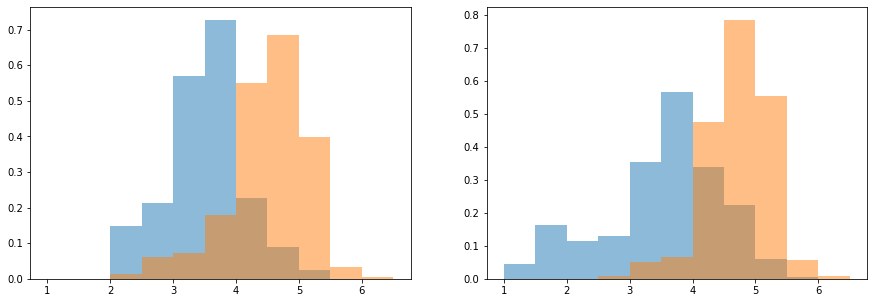

In [34]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
wgs_del_n, _, _ = plt.hist(wgs_length, bins=np.arange(1, 7, 0.5), alpha=0.5, density=True)
chip_del_n, _, _ = plt.hist(chip_length, bins=np.arange(1, 7, 0.5), alpha=0.5, density=True)

plt.subplot(1, 2, 2)
wgs_nodel_n, _, _ = plt.hist(wgs_notrans_length, bins=np.arange(1, 7, 0.5), alpha=0.5, density=True)
chip_nodel_n, _, _ = plt.hist(chip_notrans_length, bins=np.arange(1, 7, 0.5), alpha=0.5, density=True)

plt.show()

In [35]:
colors=['#ef6c00', '#4db6ac']

In [36]:
num_markers = np.array([d['num_markers_ihart.chip'] for d in wgs_deletions])
num_markers_notrans = np.array([d['num_markers_ihart.chip'] for d in wgs_notrans_deletions])

num_markers_chip = np.array([d['num_markers'] for d in chip_deletions])

(array([324.,  61.,  12.,  13.,   3.,   2.,   3.,   2.,   0.,   1.]),
 array([ 2. ,  8.8, 15.6, 22.4, 29.2, 36. , 42.8, 49.6, 56.4, 63.2, 70. ]),
 <a list of 10 Patch objects>)

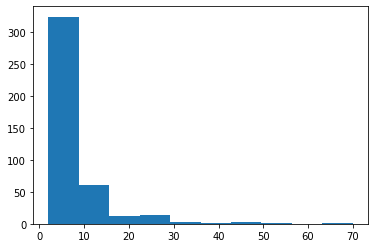

In [37]:
plt.hist(num_markers_chip)

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:82: RuntimeWarning: invalid value encountered in long_scalars
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:87: RuntimeWarning: invalid value encountered in long_scalars


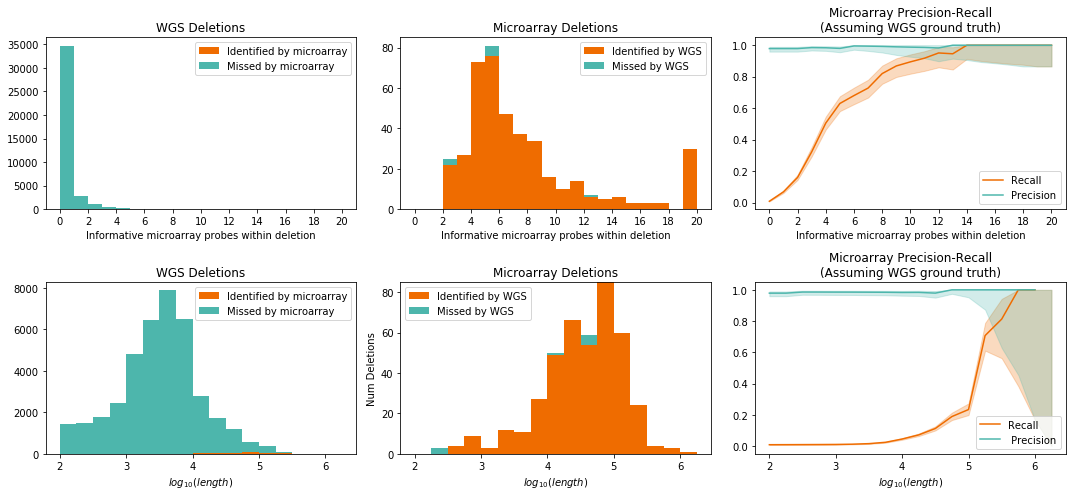

In [46]:
plt.figure(figsize=(15, 7))
ax = plt.subplot(2, 3, 1)
bins = np.arange(0, 21, 1)
plt.hist([np.clip(num_markers[wgs_is_val], 0, 20), np.clip(num_markers[~wgs_is_val], 0, 20)], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative microarray probes within deletion')
plt.title('WGS Deletions')
plt.xticks(np.arange(0, 22, 2))

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by microarray","Missed by microarray"]
plt.legend(handles, labels)

plt.subplot(2, 3, 2, sharex=ax)
plt.hist([np.clip(num_markers_chip[chip_is_val], 0, 20), np.clip(num_markers_chip[~chip_is_val], 0, 20)], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative microarray probes within deletion')
plt.title('Microarray Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by WGS","Missed by WGS"]
plt.legend(handles, labels)

#plt.subplot(1, 3, 2)
#precision, recall, _ = precision_recall_curve(wgs_is_val, num_markers)
#plt.plot(recall, precision)
#plt.xlabel('Recall')
#plt.ylabel('Precision')
#plt.title('Precision-Recall Curve')

plt.subplot(2, 3, 3, sharex=ax)
percent_val = np.zeros((21,))
percent_val_ub, percent_val_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
percent_val_chip = np.zeros((21,))
percent_val_chip_ub, percent_val_chip_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
for i in range(21):
    x = np.sum((num_markers>=i) & wgs_is_val)
    n = np.sum((num_markers>=i))
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')    

    x = np.sum((num_markers_chip>=i) & chip_is_val)
    n = np.sum(num_markers_chip>=i)
    percent_val_chip[i] = x/n
    percent_val_chip_ub[i], percent_val_chip_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')    

plt.plot(bins, percent_val, label='Recall', color=colors[0])
plt.fill_between(bins, percent_val_ub, percent_val_lb, color=colors[0], alpha=0.25)
plt.plot(bins, percent_val_chip, label='Precision', color=colors[1])
plt.fill_between(bins, percent_val_chip_ub, percent_val_chip_lb, color=colors[1], alpha=0.25)
plt.xlabel('Informative microarray probes within deletion')
plt.legend()
plt.title('Microarray Precision-Recall\n(Assuming WGS ground truth)')


bins = np.arange(2, 6.5, 0.25)
ax = plt.subplot(2, 3, 4)
chip_mark_del_n, _, _ = plt.hist([np.clip(wgs_length[wgs_is_val], 0, 6), np.clip(wgs_length[~wgs_is_val], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.title('WGS Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by microarray","Missed by microarray"]
plt.legend(handles, labels)

plt.subplot(2, 3, 5, sharex=ax)
chip_mark_del_n, _, _ = plt.hist([np.clip(chip_length[chip_is_val], 0, 6), np.clip(chip_length[~chip_is_val], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.ylabel('Num Deletions')
plt.title('Microarray Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Identified by WGS","Missed by WGS"]
plt.legend(handles, labels)

plt.subplot(2, 3, 6, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ub, percent_val_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
percent_val_chip = np.zeros((len(bins),))
percent_val_chip_ub, percent_val_chip_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
for i, j in enumerate(bins):
    x = np.sum((wgs_length>=j) & wgs_is_val)
    n = np.sum((wgs_length>=j))
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')    
    
    x = np.sum((chip_length>=j) & chip_is_val)
    n = np.sum(chip_length>=j)
    percent_val_chip[i] = x/n
    percent_val_chip_ub[i], percent_val_chip_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')    
    
plt.plot(bins, percent_val, label='Recall', color=colors[0])
plt.fill_between(bins, percent_val_ub, percent_val_lb, color=colors[0], alpha=0.25)
plt.plot(bins, percent_val_chip, label=' Precision', color=colors[1])
plt.fill_between(bins, percent_val_chip_ub, percent_val_chip_lb, color=colors[1], alpha=0.25)
plt.xlabel('$log_{10}(length)$')
plt.legend()
plt.title('Microarray Precision-Recall\n(Assuming WGS ground truth)')

plt.tight_layout()
plt.show()

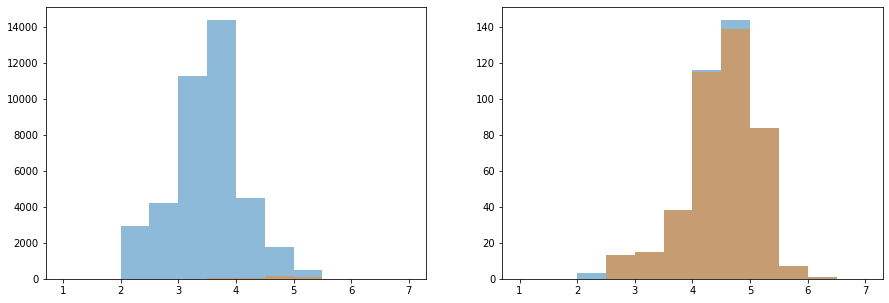

In [39]:
wgs_del_lengths = np.array([x['length'] for x in wgs_deletions])
chip_del_lengths = np.array([x['length'] for x in chip_deletions])

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
wgs_n, _, _ = plt.hist(np.log10(wgs_del_lengths), alpha=0.5, bins=np.arange(1, 7.5, 0.5))
wgs_val_n, _, _ = plt.hist(np.log10(wgs_del_lengths[wgs_is_val]), alpha=0.5, bins=np.arange(1, 7.5, 0.5))

plt.subplot(1, 2, 2)
chip_n, _, _ = plt.hist(np.log10(chip_del_lengths), alpha=0.5, bins=np.arange(1, 7.5, 0.5))
chip_val_n, _, _ = plt.hist(np.log10(chip_del_lengths[chip_is_val]), alpha=0.5, bins=np.arange(1, 7.5, 0.5))

plt.show()

In [40]:
print(np.arange(1, 7.5, 0.5))
print(wgs_val_n)
print(chip_val_n)
print(chip_n)

[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7. ]
[  0.   0.   0.   5.   1.  17.  49. 137. 102.  12.   1.   0.]
[  0.   0.   0.  13.  15.  38. 115. 139.  84.   7.   1.   0.]
[  0.   0.   3.  13.  15.  38. 116. 144.  84.   7.   1.   0.]


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


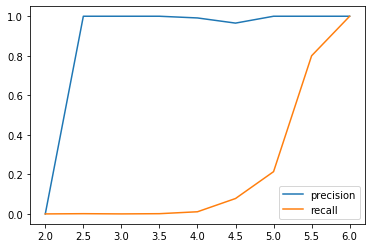

In [41]:
plt.plot(np.arange(1, 7, 0.5), chip_val_n/chip_n, label='precision')
plt.plot(np.arange(1, 7, 0.5), wgs_val_n/wgs_n, label='recall')
plt.legend()
plt.show()

In [42]:
end_offset = []
for d, sb in val_pairs:
    # start
    overlap = min(d['start_pos'], sb['start_pos']) - max(d['opt_start_pos'], sb['opt_start_pos'])
    if overlap>0:
        end_offset.append(0)
    elif d['start_pos']<sb['opt_start_pos']:
        end_offset.append(sb['opt_start_pos']-d['start_pos'])
    elif sb['start_pos']<d['opt_start_pos']:
        end_offset.append(d['opt_start_pos']-sb['start_pos'])
    else:
        print('Error')
        
    # end
    overlap = min(d['opt_end_pos'], sb['opt_end_pos']) - max(d['end_pos'], sb['end_pos'])
    if overlap>0:
        end_offset.append(0)
    elif d['opt_end_pos']<sb['end_pos']:
        end_offset.append(sb['end_pos']-d['opt_end_pos'])
    elif sb['opt_end_pos']<d['end_pos']:
        end_offset.append(d['end_pos']-sb['opt_end_pos'])
    else:
        print('Error')

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


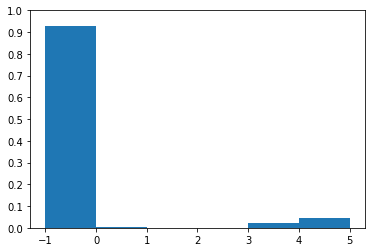

In [43]:
plt.hist(np.clip(np.log10(end_offset), -1, None), bins=np.arange(-1, 6), density=True)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

# look at a particular deletion

In [44]:
frame_start, frame_end = d['opt_start_pos']-10000, d['opt_end_pos']+10000

with open('%s/%s.phased.txt' % (chip_phase_dir, d['family']), 'r') as f:
    header = next(f).split('\t')
    first_line = next(f).strip().split('\t')
    chip_phase = np.zeros((frame_end-frame_start, len(first_line)-3))

with open('%s/%s.phased.txt' % (chip_phase_dir, d['family']), 'r') as f:
    header = next(f).split('\t')
    for line in f:
        pieces = line.strip().split('\t')
        start_pos, end_pos = [int(x) for x in pieces[-2:]]
        if pieces[0]==('chr%s' % d['chrom']) and min(frame_end, end_pos) - max(frame_start, start_pos) > 0:
            start_index, end_index = max(0, start_pos-frame_start), min(frame_end-frame_start, end_pos-frame_start)
            chip_phase[start_index:end_index, :] = np.tile(pieces[1:-2], (end_index-start_index, 1))
            
            

In [111]:
with open('%s/%s.phased.txt' % (wgs_phase_dir, d['family']), 'r') as f:
    header = next(f).split('\t')
    first_line = next(f).strip().split('\t')
    wgs_phase = np.zeros((frame_end-frame_start, len(first_line)-3))

with open('%s/%s.phased.txt' % (wgs_phase_dir, d['family']), 'r') as f:
    header = next(f).split('\t')
    for line in f:
        pieces = line.strip().split('\t')
        start_pos, end_pos = [int(x) for x in pieces[-2:]]
        if pieces[0]==('chr%s' % d['chrom']) and min(frame_end, end_pos) - max(frame_start, start_pos) > 0:
            start_index, end_index = max(0, start_pos-frame_start), min(frame_end-frame_start, end_pos-frame_start)
            wgs_phase[start_index:end_index, :] = np.tile(pieces[1:-2], (end_index-start_index, 1))
            
 

FileNotFoundError: [Errno 2] No such file or directory: '../phased_ihart.v34_del/AU3807.phased.txt'

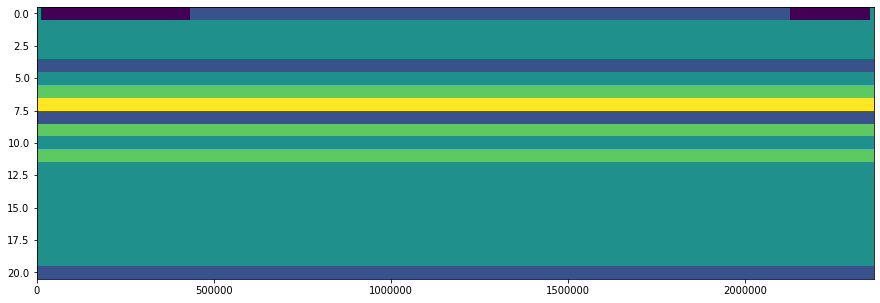

In [110]:
plt.figure(figsize=(15, 5))
plt.imshow(chip_phase.T, aspect='auto')
plt.show()